In [4]:
import asyncio

import aiohttp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from lxml import etree
from yarl import URL


## Get data

In [21]:
async def get(
    url: URL | str,
    session: aiohttp.ClientSession,
    retry: int = 4,
    type: str = "text",
) -> str:
    """Get page content from url."""
    url = URL(url)
    for _ in range(retry):
        try:
            async with session.get(url) as response:
                if type == "text":
                    return await response.text()
                elif type == "json":
                    return await response.json()
                elif type == "content":
                    return await response.content.read()
                else:
                    raise ValueError("Wrong type.")
        except aiohttp.ClientError:
            continue
    raise aiohttp.ClientError(f"Can't get page from {url}")


async with aiohttp.ClientSession() as session:
    page = await get(
        "https://www.uscyberpatriot.org/competition/current-competition/scores", session
    )
    tree = etree.HTML(page)


In [37]:
scores = [
    ("".join(e.itertext()), URL(e.xpath("./@href")[0]))
    for e in tree.xpath('//div[@id="DeltaPlaceHolderMain"]//a[contains(@href, "xlsx")]')
]

async with aiohttp.ClientSession() as session:
    tasks = [get(url, session, type="content") for _, url in scores]
    data = await asyncio.gather(*tasks)
    data = [pd.read_excel(d, engine="openpyxl") for d in data]


In [75]:
round_2, round_1 = data
# remove title rows and some metadata
round_2.columns = round_2.iloc[10]
round_2 = round_2.iloc[11:]
round_2.set_index("Team #", inplace=True)
round_2.columns.name = None

round_1.columns = round_1.iloc[7]
round_1 = round_1.iloc[9:]
round_1.set_index("Team Number", inplace=True)
round_1.columns.name = None


## Teams

In [100]:
teams = {
    "lambda": {
        "members": ["Yubo ", "Garrett", "Dobromir", "Joan", "Minh ", "Samiel"],
        "number": "15-3926",
    },
    "psi": {
        "members": ["Bibek", "Jonah", "Max", "Jase", "Joshua", "Andrew"],
        "number": "15-3927",
    },
    "mu ": {
        "members": ["Anish", "Achilleas", "Juwang", "Ann", "Dmitry", "Juan"],
        "number": "15-3928",
    },
    "phi": {
        "members": ["Katie", "Nekita", "Zoe", "Shivali", "Rhea", "BanAnh"],
        "number": "15-4561",
    },
}
teams = pd.DataFrame(teams)


## Plot

In [261]:
# colors
cmap = plt.cm.Blues
sns.set_palette(sns.color_palette(cmap(np.linspace(0.2, 0.8, 6))))
sns.set_style("whitegrid")
sns.axes_style()['font.family'] = 'serif'
sns.axes_style()['axes.edgecolor'] = 'transparent'
sns.set_context("poster")


In [266]:
# use latex
mpl.rc("text", usetex=True)
mpl.rc("font", family="serif")


In [289]:
def hist(df, column, text=False, gradient=True, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    defaults = dict(data=df[column], ax=ax, kde=True, bins=20, alpha=0.5)
    defaults.update(kwargs)
    rects = sns.histplot(**defaults)
    if text:
        for rect in rects.patches:
            height = rect.get_height()
            ax.text(
                rect.get_x() + rect.get_width() / 2,
                height,
                f"{height:.0f}",
                ha="center",
                va="bottom",
                fontsize=12,
            )
    if gradient:
        for rect in rects.patches:
            height = rect.get_height()
            rect.set_facecolor(
                cmap(height / max(patch.get_height() for patch in rects.patches) - 0.2)
            )


def label_position(x, text, ax=None, line_kwargs={}, text_kwargs={}):
    """Draw a vertical line and label it."""
    if ax is None:
        ax = plt.gca()
    defaults = dict(color="black", linestyle="--", linewidth=1)
    defaults.update(line_kwargs)
    ax.axvline(x, **defaults)
    defaults = dict(
        x=x,
        y=ax.get_ylim()[1] + 0.01 * (ax.get_ylim()[1] - ax.get_ylim()[0]),
        s=text,
        ha="center",
        va="bottom",
        fontsize=12,
    )
    defaults.update(text_kwargs)
    ax.text(**defaults)


def label_range(lo, hi, text, ax=None, line_kwargs={}, text_kwargs={}):
    """Draw a vertical line and label it."""
    if ax is None:
        ax = plt.gca()
    defaults = dict(color="black", linestyle="--", linewidth=1)
    defaults.update(line_kwargs)
    ax.axvspan(lo, hi, **defaults)
    defaults = dict(
        x=(lo + hi) / 2,
        y=ax.get_ylim()[1] + 0.01 * (ax.get_ylim()[1] - ax.get_ylim()[0]),
        s=text,
        ha="center",
        va="bottom",
        fontsize=12,
        alpha=0.5,
    )
    defaults.update(text_kwargs)
    ax.text(**defaults)


def label_team(df, hist_column, ax=None):
    """Label the team on the histogram."""

    if ax is None:
        ax = plt.gca()
    for (team_name, team_number) in teams.loc["number"].to_dict().items():
        percentile = df[hist_column].rank()[team_number] / len(df)
        label_position(
            df.loc[team_number, hist_column],
            f"$\\{team_name}\\,{percentile:.2f}$",
            ax=ax,
            line_kwargs={"color": cmap(percentile)},
            text_kwargs={"color": cmap(0.9), "fontsize": 10},
        )


def label_37(df, column, ax):
    # label 30% and 70%
    zero, one_hundred = ax.get_xlim()
    thirty, seventy = df[column].quantile([0.3, 0.7])

    y = ax.get_ylim()[1] + 0.05 * (ax.get_ylim()[1] - ax.get_ylim()[0])
    label_range(
        thirty,
        seventy,
        "30\% - 70\%",
        ax=ax,
        line_kwargs={"color": cmap(0.5), "alpha": 0.2, "zorder": -1},
        text_kwargs={"y": y, "color": "black", "alpha": 0.7},
    )
    label_range(
        zero,
        thirty,
        "0\% - 30\%",
        ax=ax,
        line_kwargs={"color": cmap(0.2), "zorder": -1, "alpha": 0.2},
        text_kwargs={"y": y, "color": "black", "alpha": 0.7},
    )
    label_range(
        seventy,
        one_hundred,
        "70\% - 100\%",
        ax=ax,
        line_kwargs={"color": cmap(0.8), "zorder": -1, "alpha": 0.2},
        text_kwargs={"y": y, "color": "black", "alpha": 0.7},
    )


In [291]:
round_2.loc[:, "Total Score"] = (
    round_2["Round 2 Image Score"] + round_2["Round 2 Cisco Score"]
)


c:\Users\Cao20\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


In [296]:
# now, only consider Georgia
round_2_georgia = round_2[round_2["Location"] == "GA"]
round_1_georgia = round_1[round_1["Location"] == "GA"]


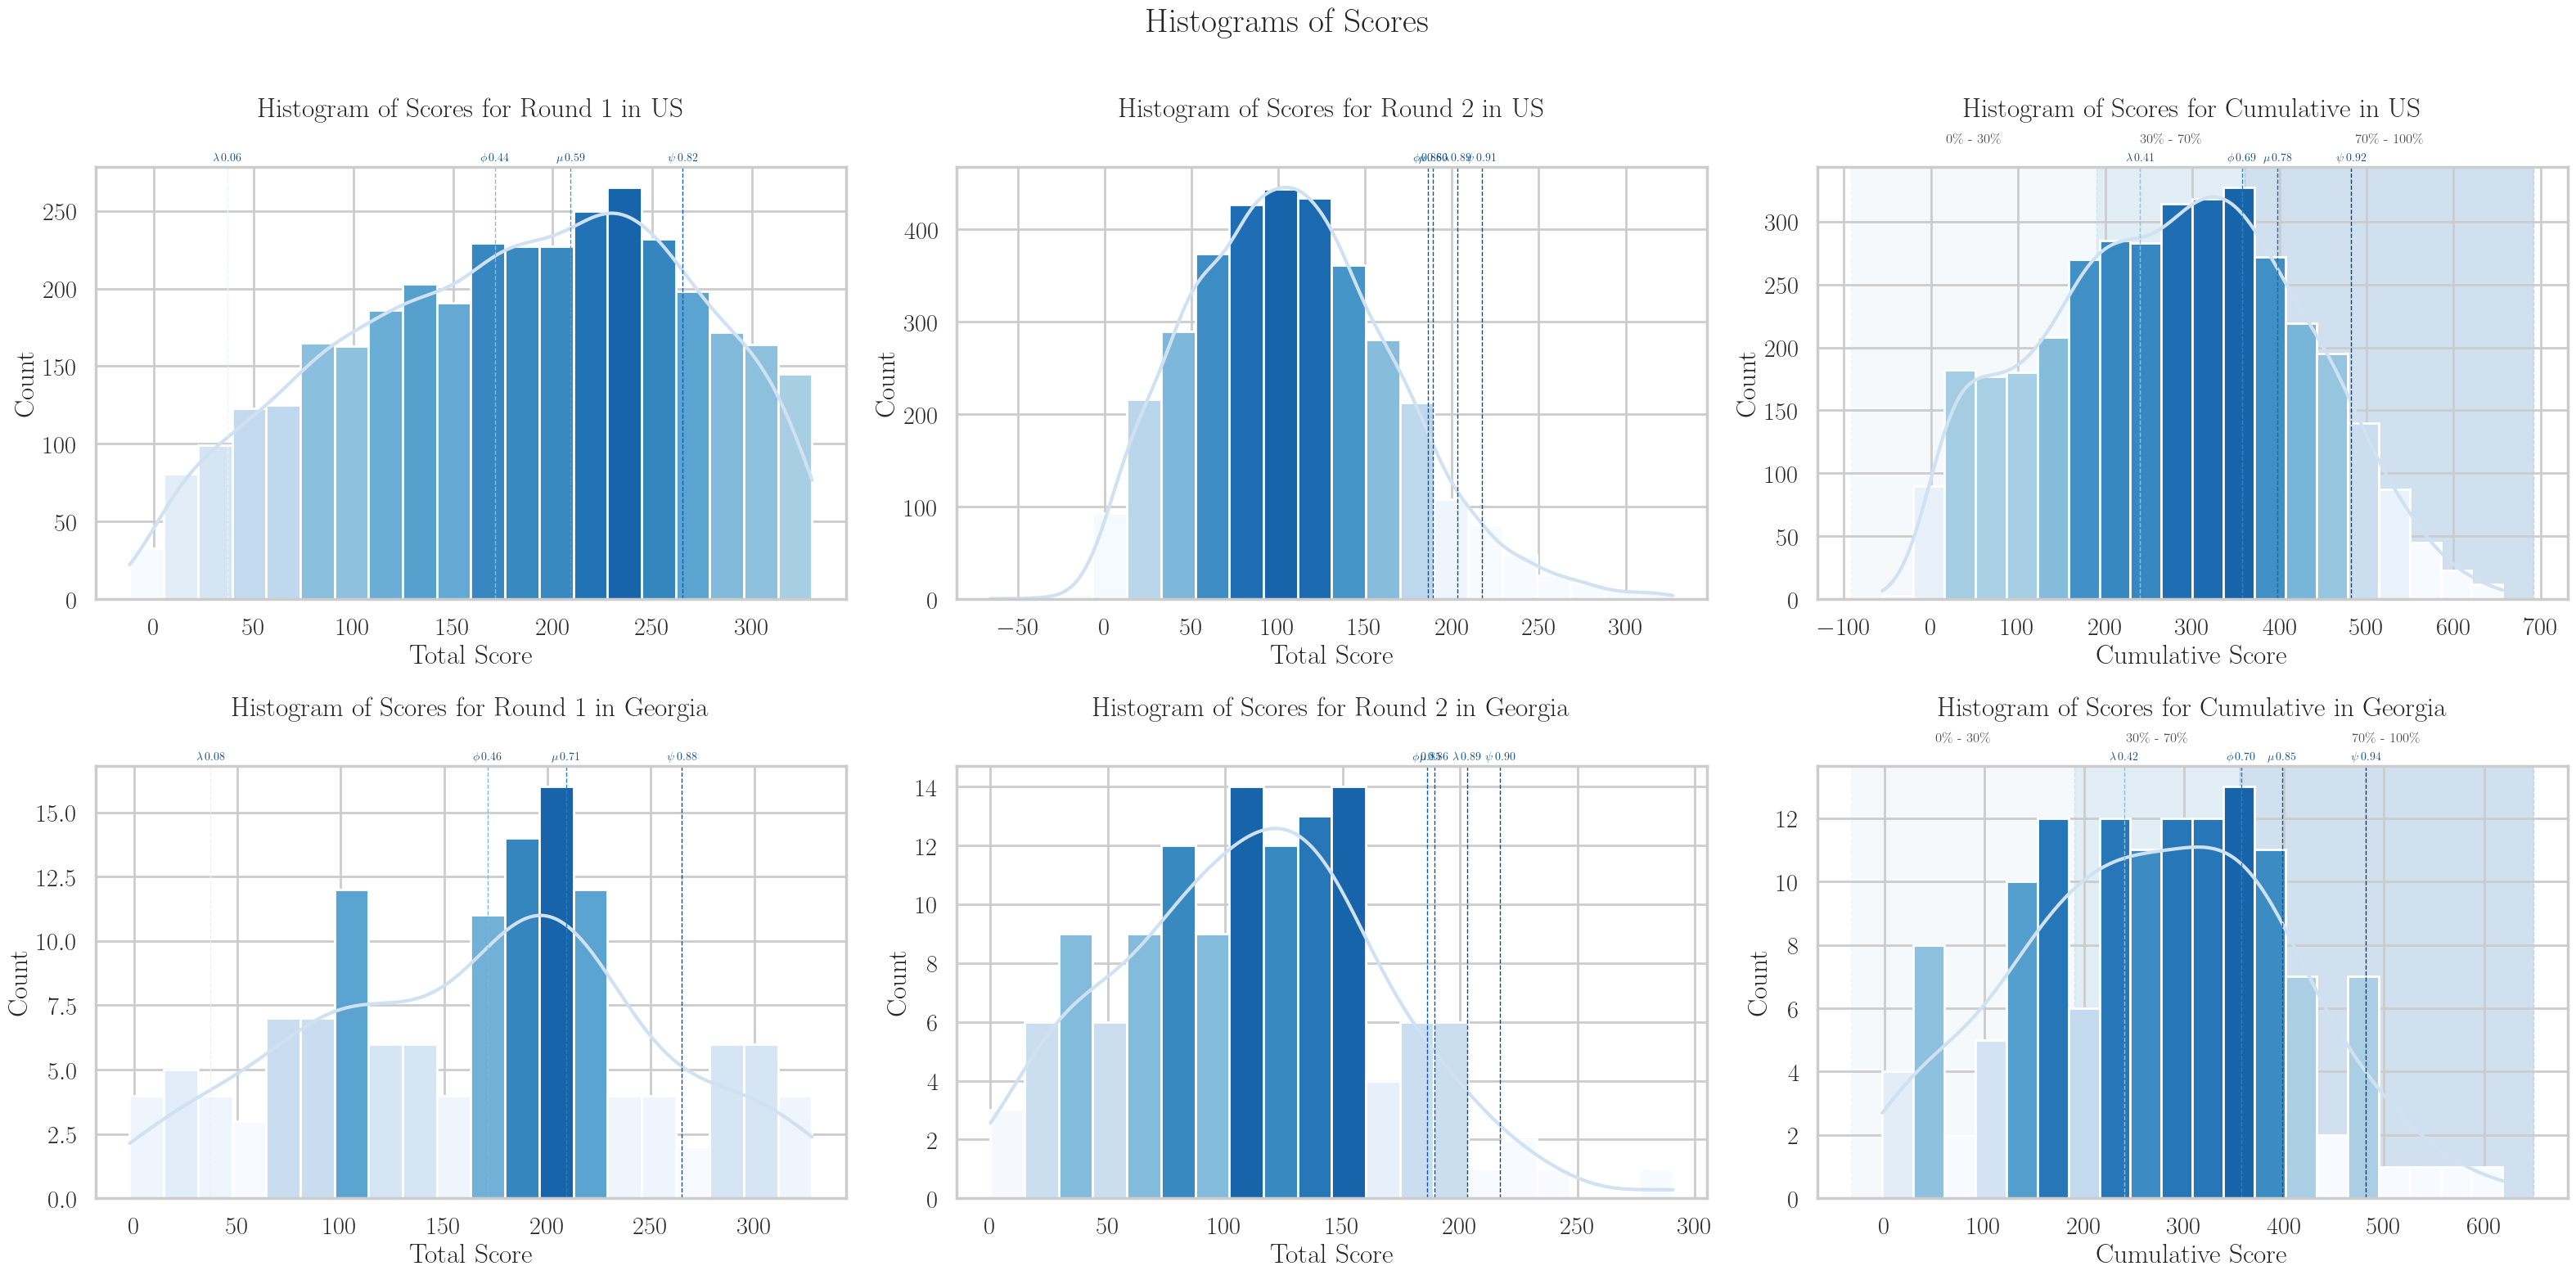

In [315]:
# make a 2x3 grid of plots
fig, axes = plt.subplots(2, 3, figsize=(32, 15))
# plot the histograms in r1, r2, and c
# in states, and in georgia
for (title, column, df, ax) in zip(
    ["Round 1", "Round 2", "Cumulative"],
    ["Total Score", "Total Score", "Cumulative Score"],
    [round_1, round_2, round_2],
    axes[0],
):
    hist(df=df, column=column, text=False, ax=ax)
    label_team(df, column, ax=ax)
    if column == "Cumulative Score":
        label_37(df, column, ax)
    ax.set_title(f"Histogram of Scores for {title} in US", y=1.1)

for (title, column, df, ax) in zip(
    ["Round 1", "Round 2", "Cumulative"],
    ["Total Score", "Total Score", "Cumulative Score"],
    [round_1_georgia, round_2_georgia, round_2_georgia],
    axes[1],
):
    hist(df=df, column=column, text=False, ax=ax)
    label_team(df, column, ax=ax)
    if column == "Cumulative Score":
        label_37(df, column, ax)
    ax.set_title(f"Histogram of Scores for {title} in Georgia", y=1.1)

fig.tight_layout()
fig.suptitle("Histograms of Scores", y=1.05, fontsize=30)
fig.savefig("histograms.png", dpi=300)
